# Model Selection
---

In [2]:
import joblib as jl
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import maxabs_scale
from sklearn.metrics import *

In [3]:
# Compute accuracy, precision, recall and AUPRC for each model
def compute_metrics(model, data):
    X_test = data["Xtest"]
    X_train = data["Xtrain"]
    y_test = data["Ytest"]
    y_train = data["Ytrain"]

    y_train_pred = model.predict(X_train)
    y_train_true = y_train
    y_test_pred = model.predict(X_test)
    y_test_true = y_test
    accuracy_test = accuracy_score(y_test_true, y_test_pred)
    accuracy_train = accuracy_score(y_train_true, y_train_pred)

    f1_score_test = f1_score(y_test_true, y_test_pred, average="weighted")
    f1_score_train = f1_score(y_train_true, y_train_pred, average="weighted")
    # precision = sk.metrics.precision_score(y_true, y_pred)
    # recall = sk.metrics.recall_score(y_true, y_pred)
    # auprc = sk.metrics.average_precision_score(y_true, y_pred, average='micro')
    return accuracy_test, accuracy_train, f1_score_test, f1_score_train


def compute_metrics_large(model, data):
    X_test = data["Xtest"]
    X_train = data["Xtrain"]
    y_test = data["Ytest"]
    y_train = data["Ytrain"]

    y_train_pred = model.predict(X_train)
    y_train_true = y_train
    y_test_pred = model.predict(X_test)
    y_test_true = y_test

    # Accuracy
    accuracy_test = accuracy_score(y_test_true, y_test_pred)
    accuracy_train = accuracy_score(y_train_true, y_train_pred)

    # Precision, Recall, F1-score
    precision_test, recall_test, _, _ = precision_recall_fscore_support(
        y_test_true, y_test_pred, average="weighted"
    )
    precision_train, recall_train, _, _ = precision_recall_fscore_support(
        y_train_true, y_train_pred, average="weighted"
    )

    # Precision-Recall Curve and AUC-PR
    y_test_bin = label_binarize(y_test_true, classes=np.unique(y_test_true))
    probas_pred = model.predict_proba(X_test)
    precision_curve, recall_curve, _ = precision_recall_curve(
        y_test_bin.ravel(), probas_pred.ravel()
    )
    auc_pr = auc(recall_curve, precision_curve)

    return {
        "accuracy_test": accuracy_test,
        "accuracy_train": accuracy_train,
        "precision_test": precision_test,
        "recall_test": recall_test,
        "precision_train": precision_train,
        "recall_train": recall_train,
        "auc_pr": auc_pr,
    }

### Models With Only Symptoms One Hot

In [3]:
# Load the models
path = "../models/"
mod_names = ["log_reg_classic", "RF_classic", "MLP_classic"]

log_reg = jl.load(path + mod_names[0] + ".joblib")
random_forest = jl.load(path + mod_names[1] + ".joblib")
MLP = jl.load(path + mod_names[2] + ".joblib")

# Load the data
path = "../features/normalized/"
data_names = ["random_sample_symptoms"]

symptoms = np.load(path + data_names[0] + ".npz")
data = symptoms

In [4]:
# create a dataframe with model names and metrics and the corresponding values
metrics = ["accuracy_test", "accuracy_train", "f1_score_test", "f1_score_train"]
df = pd.DataFrame(columns=metrics, index=mod_names)

df.loc["log_reg_classic", metrics] = compute_metrics(log_reg, data)
df.loc["RF_classic", metrics] = compute_metrics(random_forest, data)
df.loc["MLP_classic", metrics] = compute_metrics(MLP, data)

df

,accuracy_test,accuracy_train
log_reg_classic,0.893239,0.899494
RF_classic,0.873186,0.880491
MLP_classic,0.888464,0.89386


C:\Users\Cristian\AppData\Local\Temp\ipykernel_18296\745103858.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_test = cm.get_cmap('Blues')
C:\Users\Cristian\AppData\Local\Temp\ipykernel_18296\745103858.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_train = cm.get_cmap('Reds')


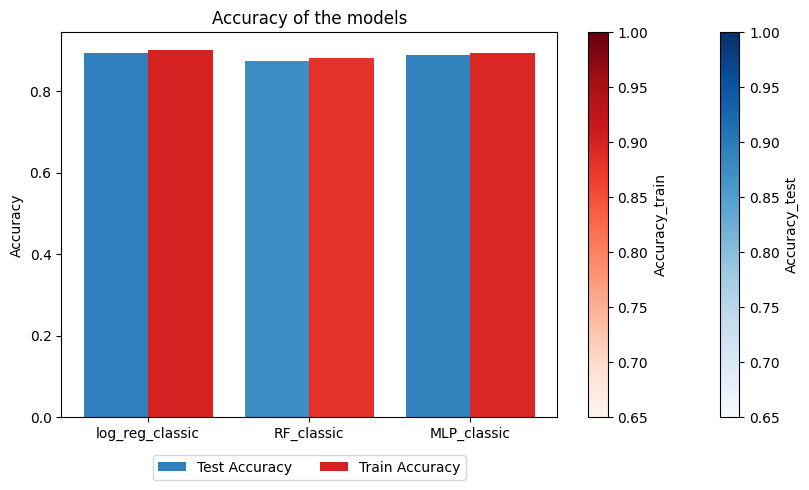

In [5]:
accuracy_test_values = df["accuracy_test"]
accuracy_train_values = df["accuracy_train"]

# Create a colormap
cmap_test = cm.get_cmap("Blues")
cmap_train = cm.get_cmap("Reds")

# Normalize the data to map it to the colormap
norm_test = Normalize(vmin=0.65, vmax=1)
norm_train = Normalize(vmin=0.65, vmax=1)

# Get the colors for each bar based on the normalized accuracy values
colors_test = [cmap_test(norm_test(value)) for value in accuracy_test_values]
colors_train = [cmap_train(norm_train(value)) for value in accuracy_train_values]

# Plot the bar chart with colored bars for accuracy_test

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
bars_test = ax.bar(
    np.arange(len(mod_names)) - 0.2,
    accuracy_test_values,
    width=0.4,
    color=colors_test,
    label="Test Accuracy",
)

# Plot the bar chart with colored bars for accuracy_train
bars_train = ax.bar(
    np.arange(len(mod_names)) + 0.2,
    accuracy_train_values,
    width=0.4,
    color=colors_train,
    label="Train Accuracy",
)

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of the models")
ax.set_xticks(np.arange(len(mod_names)))
ax.set_xticklabels(mod_names)
ax.legend()

# Add a colorbar to show the mapping of values to colors
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_test, cmap=cmap_test), ax=ax)
cbar.set_label("Accuracy_test")
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_train, cmap=cmap_train), ax=ax)
cbar.set_label("Accuracy_train")

ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=False, ncol=2
)

plt.show()

### Models With New Features

In [3]:
# Load the models
path = "../models/"
mod_names = ["log_reg_mix_norm", "RF_mix_norm", "MLP_mix_norm"]

log_reg = jl.load(path + mod_names[0] + ".joblib")
random_forest = jl.load(path + mod_names[1] + ".joblib")
MLP = jl.load(path + mod_names[2] + ".joblib")

# Load the data
path = "../features/normalized/"
data_names = ["LR_mix_data_norm", "RF_mix_data_norm", "MLP_mix_data_norm"]

lr_data = np.load(path + data_names[0] + ".npz")
rf_data = np.load(path + data_names[1] + ".npz")
mlp_data = np.load(path + data_names[2] + ".npz")

In [4]:
# create a dataframe with model names and metrics and the corresponding values
metrics = ["accuracy_test", "accuracy_train", "f1_score_test", "f1_score_train"]
df = pd.DataFrame(columns=metrics, index=mod_names)

df.loc["log_reg_mix_norm", metrics] = compute_metrics(log_reg, lr_data)
df.loc["RF_mix_norm", metrics] = compute_metrics(random_forest, rf_data)
df.loc["MLP_mix_norm", metrics] = compute_metrics(MLP, mlp_data)

df

,accuracy_test,accuracy_train
log_reg_mix_norm,0.892284,0.933824
RF_mix_norm,0.870512,0.974838
MLP_mix_norm,0.883117,0.959893


C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\745103858.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_test = cm.get_cmap('Blues')
C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\745103858.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_train = cm.get_cmap('Reds')


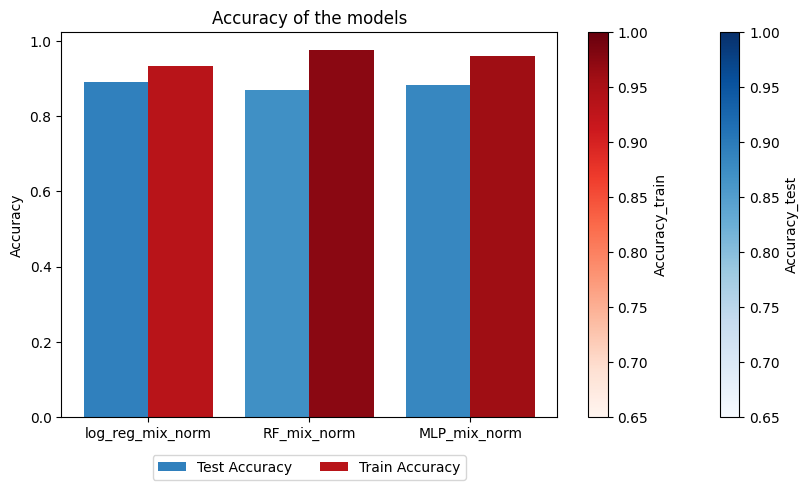

In [5]:
accuracy_test_values = df["accuracy_test"]
accuracy_train_values = df["accuracy_train"]

# Create a colormap
cmap_test = cm.get_cmap("Blues")
cmap_train = cm.get_cmap("Reds")

# Normalize the data to map it to the colormap
norm_test = Normalize(vmin=0.65, vmax=1)
norm_train = Normalize(vmin=0.65, vmax=1)

# Get the colors for each bar based on the normalized accuracy values
colors_test = [cmap_test(norm_test(value)) for value in accuracy_test_values]
colors_train = [cmap_train(norm_train(value)) for value in accuracy_train_values]

# Plot the bar chart with colored bars for accuracy_test

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
bars_test = ax.bar(
    np.arange(len(mod_names)) - 0.2,
    accuracy_test_values,
    width=0.4,
    color=colors_test,
    label="Test Accuracy",
)

# Plot the bar chart with colored bars for accuracy_train
bars_train = ax.bar(
    np.arange(len(mod_names)) + 0.2,
    accuracy_train_values,
    width=0.4,
    color=colors_train,
    label="Train Accuracy",
)

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of the models")
ax.set_xticks(np.arange(len(mod_names)))
ax.set_xticklabels(mod_names)
ax.legend()

# Add a colorbar to show the mapping of values to colors
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_test, cmap=cmap_test), ax=ax)
cbar.set_label("Accuracy_test")
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_train, cmap=cmap_train), ax=ax)
cbar.set_label("Accuracy_train")

ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=False, ncol=2
)

plt.show()

### Compare the two best models

In [6]:
# Load the models
path = "../models/"
mod_names = ["log_reg_classic", "log_reg_mix_norm"]

classic = jl.load(path + mod_names[0] + ".joblib")
mix = jl.load(path + mod_names[1] + ".joblib")

# Load the data
path = "../features/normalized/"
data_names = ["random_sample_symptoms", "LR_mix_data_norm"]

data_classic = np.load(path + data_names[0] + ".npz")
data_mix = np.load(path + data_names[1] + ".npz")

In [7]:
# create a dataframe with model names and metrics and the corresponding values
metrics = ["accuracy_test", "accuracy_train", "f1_score_test", "f1_score_train"]
df = pd.DataFrame(columns=metrics, index=mod_names)

df.loc["log_reg_mix_norm", metrics] = compute_metrics(mix, data_mix)
# df.loc['random_forest', metrics] = compute_metrics(random_forest, data_random_forest)
df.loc["log_reg_classic", metrics] = compute_metrics(classic, data_classic)

df

,accuracy_test,accuracy_train
log_reg_classic,0.893239,0.899494
log_reg_mix_norm,0.892284,0.933824


C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\745103858.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_test = cm.get_cmap('Blues')
C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\745103858.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_train = cm.get_cmap('Reds')


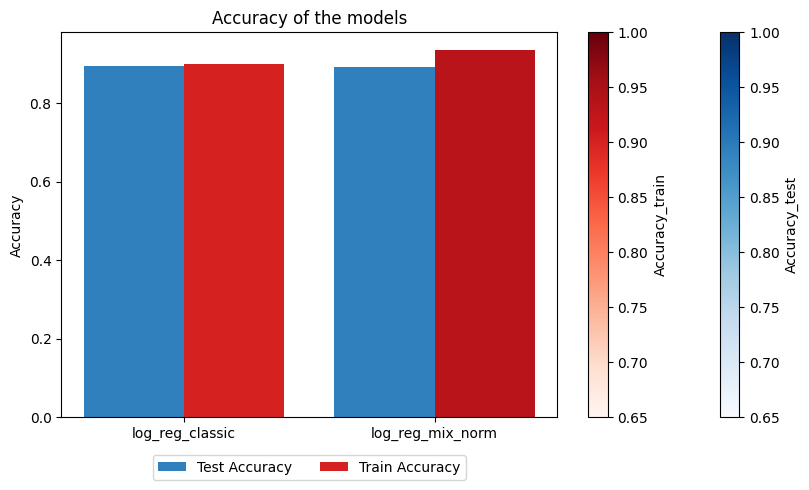

In [8]:
accuracy_test_values = df["accuracy_test"]
accuracy_train_values = df["accuracy_train"]

# Create a colormap
cmap_test = cm.get_cmap("Blues")
cmap_train = cm.get_cmap("Reds")

# Normalize the data to map it to the colormap
norm_test = Normalize(vmin=0.65, vmax=1)
norm_train = Normalize(vmin=0.65, vmax=1)

# Get the colors for each bar based on the normalized accuracy values
colors_test = [cmap_test(norm_test(value)) for value in accuracy_test_values]
colors_train = [cmap_train(norm_train(value)) for value in accuracy_train_values]

# Plot the bar chart with colored bars for accuracy_test

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
bars_test = ax.bar(
    np.arange(len(mod_names)) - 0.2,
    accuracy_test_values,
    width=0.4,
    color=colors_test,
    label="Test Accuracy",
)

# Plot the bar chart with colored bars for accuracy_train
bars_train = ax.bar(
    np.arange(len(mod_names)) + 0.2,
    accuracy_train_values,
    width=0.4,
    color=colors_train,
    label="Train Accuracy",
)

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of the models")
ax.set_xticks(np.arange(len(mod_names)))
ax.set_xticklabels(mod_names)
ax.legend()

# Add a colorbar to show the mapping of values to colors
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_test, cmap=cmap_test), ax=ax)
cbar.set_label("Accuracy_test")
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_train, cmap=cmap_train), ax=ax)
cbar.set_label("Accuracy_train")

ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=False, ncol=2
)

plt.show()

### Compare the two best models trained with full data

In [9]:
# Load the models
path = "../models/"
mod_names = ["log_reg_classic_full_data", "log_reg_mix_full_data_norm"]

classic = jl.load(path + mod_names[0] + ".joblib")
mix = jl.load(path + mod_names[1] + ".joblib")

# Load the data
path = "../features/normalized/"
data_names = ["LR_classic_full_data", "LR_mix_full_data_norm"]

data_classic = np.load(path + data_names[0] + ".npz")
data_mix = np.load(path + data_names[1] + ".npz")

In [10]:
# create a dataframe with model names and metrics and the corresponding values
metrics = ["accuracy_test", "accuracy_train", "f1_score_test", "f1_score_train"]
df = pd.DataFrame(columns=metrics, index=mod_names)

df.loc["log_reg_mix_full_data_norm", metrics] = compute_metrics(mix, data_mix)
# df.loc['random_forest', metrics] = compute_metrics(random_forest, data_random_forest)
df.loc["log_reg_classic_full_data", metrics] = compute_metrics(classic, data_classic)

df

,accuracy_test,accuracy_train
log_reg_classic_full_data,0.91992,0.929534
log_reg_mix_full_data_norm,0.921769,0.927334


In [11]:
mix = compute_metrics(mix, data_mix)
classic = compute_metrics(classic, data_classic)

print("mix", mix)
print("classic", classic)

mix (0.9217691622103387, 0.9273340017825312)
classic (0.9199197860962567, 0.9295343137254902)


C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\1362933683.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_test = cm.get_cmap('Blues')
C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\1362933683.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_train = cm.get_cmap('Reds')


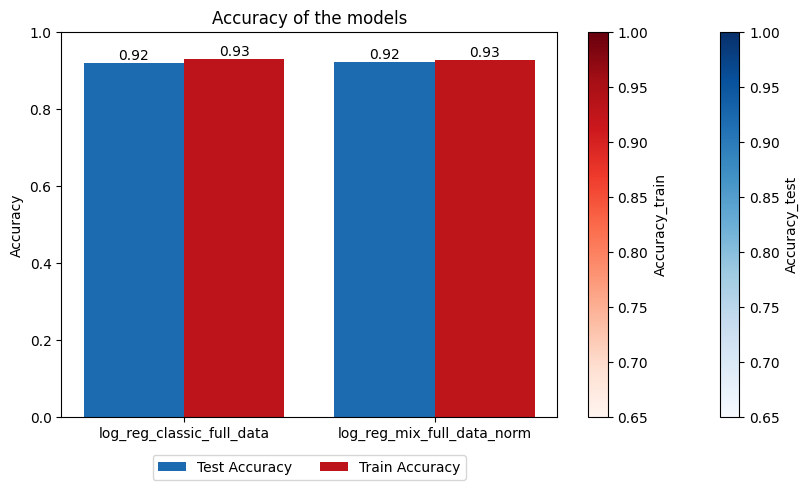

In [12]:
accuracy_test_values = df["accuracy_test"]
accuracy_train_values = df["accuracy_train"]

# Create a colormap
cmap_test = cm.get_cmap("Blues")
cmap_train = cm.get_cmap("Reds")

# Normalize the data to map it to the colormap
norm_test = Normalize(vmin=0.65, vmax=1)
norm_train = Normalize(vmin=0.65, vmax=1)

# Get the colors for each bar based on the normalized accuracy values
colors_test = [cmap_test(norm_test(value)) for value in accuracy_test_values]
colors_train = [cmap_train(norm_train(value)) for value in accuracy_train_values]

# Plot the bar chart with colored bars for accuracy_test

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
bars_test = ax.bar(
    np.arange(len(mod_names)) - 0.2,
    accuracy_test_values,
    width=0.4,
    color=colors_test,
    label="Test Accuracy",
)

# Plot the bar chart with colored bars for accuracy_train
bars_train = ax.bar(
    np.arange(len(mod_names)) + 0.2,
    accuracy_train_values,
    width=0.4,
    color=colors_train,
    label="Train Accuracy",
)

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of the models")
ax.set_xticks(np.arange(len(mod_names)))
ax.set_xticklabels(mod_names)
ax.set_ylim([0, 1.0001])
ax.bar_label(bars_test, fmt="%.2f")
ax.bar_label(bars_train, fmt="%.2f")
ax.legend()

# Add a colorbar to show the mapping of values to colors
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_test, cmap=cmap_test), ax=ax)
cbar.set_label("Accuracy_test")
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_train, cmap=cmap_train), ax=ax)
cbar.set_label("Accuracy_train")

ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=False, ncol=2
)

plt.show()

### EXTRA: COMPARE THE MLP MIX ON FULL DATA VS THE LOG REG MIX ON FULL DATA

In [13]:
# Load the models
path = "../models/"
mod_names = ["MLP_mix_full_data_norm", "log_reg_mix_full_data_norm"]

classic = jl.load(path + mod_names[0] + ".joblib")
mix = jl.load(path + mod_names[1] + ".joblib")

# Load the data
path = "../features/normalized/"
data_names = ["MLP_mix_full_data_norm", "LR_mix_full_data_norm"]

data_classic = np.load(path + data_names[0] + ".npz")
data_mix = np.load(path + data_names[1] + ".npz")

In [14]:
# create a dataframe with model names and metrics and the corresponding values
metrics = ["accuracy_test", "accuracy_train", "f1_score_test", "f1_score_train"]
df = pd.DataFrame(columns=metrics, index=mod_names)

df.loc["log_reg_mix_full_data_norm", metrics] = compute_metrics(mix, data_mix)
# df.loc['random_forest', metrics] = compute_metrics(random_forest, data_random_forest)
df.loc["MLP_mix_full_data_norm", metrics] = compute_metrics(classic, data_classic)

df

,accuracy_test,accuracy_train
MLP_mix_full_data_norm,0.913971,0.937494
log_reg_mix_full_data_norm,0.921769,0.927334


In [15]:
mix = compute_metrics_large(mix, data_mix)
classic = compute_metrics_large(classic, data_classic)

print("mix", mix)
print("classic", classic)

C:\Users\Cristian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cristian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mix {'accuracy_test': 0.9217691622103387, 'accuracy_train': 0.9273340017825312, 'precision_test': 0.926005393028901, 'recall_test': 0.9217691622103387, 'precision_train': 0.9316480025894597, 'recall_train': 0.9273340017825312, 'auc_pr': 0.9802339834870386}
classic {'accuracy_test': 0.9139705882352941, 'accuracy_train': 0.9374944295900178, 'precision_test': 0.917787338946292, 'recall_test': 0.9139705882352941, 'precision_train': 0.9409572561069367, 'recall_train': 0.9374944295900178, 'auc_pr': 0.977696525707826}


C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\1362933683.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_test = cm.get_cmap('Blues')
C:\Users\Cristian\AppData\Local\Temp\ipykernel_13616\1362933683.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_train = cm.get_cmap('Reds')


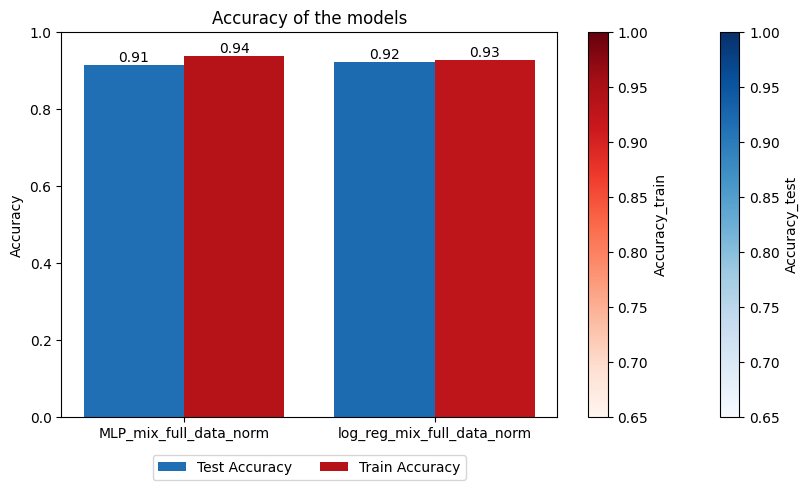

In [16]:
accuracy_test_values = df["accuracy_test"]
accuracy_train_values = df["accuracy_train"]

# Create a colormap
cmap_test = cm.get_cmap("Blues")
cmap_train = cm.get_cmap("Reds")

# Normalize the data to map it to the colormap
norm_test = Normalize(vmin=0.65, vmax=1)
norm_train = Normalize(vmin=0.65, vmax=1)

# Get the colors for each bar based on the normalized accuracy values
colors_test = [cmap_test(norm_test(value)) for value in accuracy_test_values]
colors_train = [cmap_train(norm_train(value)) for value in accuracy_train_values]

# Plot the bar chart with colored bars for accuracy_test

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
bars_test = ax.bar(
    np.arange(len(mod_names)) - 0.2,
    accuracy_test_values,
    width=0.4,
    color=colors_test,
    label="Test Accuracy",
)

# Plot the bar chart with colored bars for accuracy_train
bars_train = ax.bar(
    np.arange(len(mod_names)) + 0.2,
    accuracy_train_values,
    width=0.4,
    color=colors_train,
    label="Train Accuracy",
)

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of the models")
ax.set_xticks(np.arange(len(mod_names)))
ax.set_xticklabels(mod_names)
ax.set_ylim([0, 1.0001])
ax.bar_label(bars_test, fmt="%.2f")
ax.bar_label(bars_train, fmt="%.2f")
ax.legend()

# Add a colorbar to show the mapping of values to colors
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_test, cmap=cmap_test), ax=ax)
cbar.set_label("Accuracy_test")
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_train, cmap=cmap_train), ax=ax)
cbar.set_label("Accuracy_train")

ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=False, ncol=2
)

plt.show()

## Try to test the results on the not balanced data

In [4]:
# Try to use real data as test data
# Load the models
path = "../models/"
mod_names = ["log_reg_classic_full_data", "log_reg_mix_full_data_norm"]

classic = jl.load(path + mod_names[0] + ".joblib")
mix = jl.load(path + mod_names[1] + ".joblib")

# Load the data
path = "../features/normalized/"
data_names = [
    "symptoms",
    "ks_level_2_norm",
    "community_count_norm",
    "community_size_norm",
]
data_names_tmp = ["LR_classic_full_data", "LR_mix_full_data_norm"]

data_classic_tmp = np.load(path + data_names_tmp[0] + ".npz")
data_mix_tmp = np.load(path + data_names_tmp[1] + ".npz")

symptoms = np.load(path + data_names[0] + ".npz")
ks_level_2_norm = np.load(path + data_names[1] + ".npz")
community_count = np.load(path + data_names[2] + ".npz")
community_size = np.load(path + data_names[3] + ".npz")

# data_classic = np.concatenate((symptoms['X'], symptoms['y'].reshape(symptoms['y'].shape[0],1)), axis=1)
# data_mix = np.concatenate((community_size['X'], ks_level_2_norm['X'], community_count['X'], community_count['y'].reshape(symptoms['y'].shape[0],1)), axis=1)

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    symptoms["X"], symptoms["y"], test_size=0.5, random_state=42
)
np.savez_compressed(
    path + "symptoms_final_model_classic",
    Xtest=X_test,
    Xtrain=data_classic_tmp["Xtrain"],
    Ytest=y_test,
    Ytrain=data_classic_tmp["Ytrain"],
)

data_mix = np.concatenate(
    (
        community_size["X"],
        community_size["X"],
        ks_level_2_norm["X"],
        community_count["X"],
        community_count["y"].reshape(symptoms["y"].shape[0], 1),
    ),
    axis=1,
)
X_train, X_test, y_train, y_test = train_test_split(
    data_mix[:, :-1], data_mix[:, -1], test_size=0.5, random_state=42
)

np.savez_compressed(
    path + "mixed_final_model_mix",
    Xtest=X_test,
    Xtrain=data_mix_tmp["Xtrain"],
    Ytest=y_test,
    Ytrain=data_mix_tmp["Ytrain"],
)

# load the new final data
data_names = ["symptoms_final_model_classic", "mixed_final_model_mix"]

data_classic = np.load(path + data_names[0] + ".npz")
data_mix = np.load(path + data_names[1] + ".npz")

In [5]:
# create a dataframe with model names and metrics and the corresponding values
metrics = ["accuracy_test", "accuracy_train", "f1_score_test", "f1_score_train"]
df = pd.DataFrame(columns=metrics, index=mod_names)

df.loc["log_reg_mix_full_data_norm", metrics] = compute_metrics(mix, data_mix)
# df.loc['random_forest', metrics] = compute_metrics(random_forest, data_random_forest)
df.loc["log_reg_classic_full_data", metrics] = compute_metrics(classic, data_classic)


df

,accuracy_test,accuracy_train,f1_score_test,f1_score_train
log_reg_classic_full_data,0.872288,0.928955,0.874837,0.928586
log_reg_mix_full_data_norm,0.869679,0.927334,0.872677,0.92673


C:\Users\Cristian\AppData\Local\Temp\ipykernel_21800\3655933965.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_test = cm.get_cmap("Blues")
C:\Users\Cristian\AppData\Local\Temp\ipykernel_21800\3655933965.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_train = cm.get_cmap("Reds")


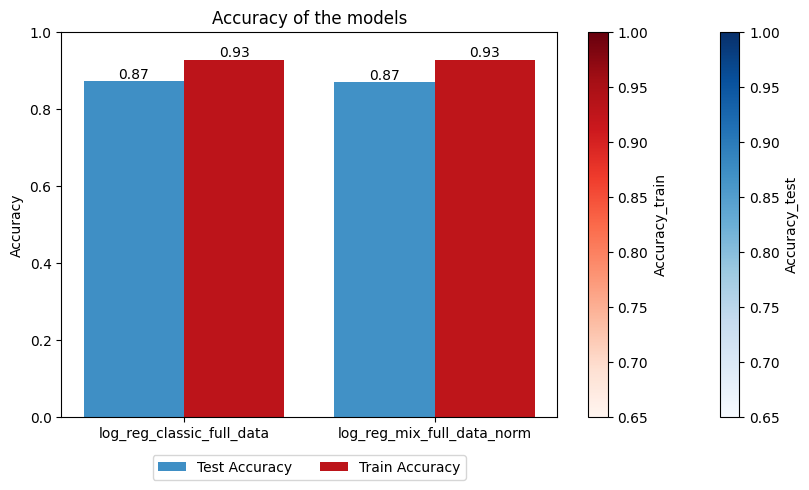

In [9]:
accuracy_test_values = df["accuracy_test"]
accuracy_train_values = df["accuracy_train"]

# Create a colormap
cmap_test = cm.get_cmap("Blues")
cmap_train = cm.get_cmap("Reds")

# Normalize the data to map it to the colormap
norm_test = Normalize(vmin=0.65, vmax=1)
norm_train = Normalize(vmin=0.65, vmax=1)

# Get the colors for each bar based on the normalized accuracy values
colors_test = [cmap_test(norm_test(value)) for value in accuracy_test_values]
colors_train = [cmap_train(norm_train(value)) for value in accuracy_train_values]

# Plot the bar chart with colored bars for accuracy_test

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
bars_test = ax.bar(
    np.arange(len(mod_names)) - 0.2,
    accuracy_test_values,
    width=0.4,
    color=colors_test,
    label="Test Accuracy",
)

# Plot the bar chart with colored bars for accuracy_train
bars_train = ax.bar(
    np.arange(len(mod_names)) + 0.2,
    accuracy_train_values,
    width=0.4,
    color=colors_train,
    label="Train Accuracy",
)

ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of the models")
ax.set_xticks(np.arange(len(mod_names)))
ax.set_xticklabels(mod_names)
ax.set_ylim([0, 1.0001])
ax.bar_label(bars_test, fmt="%.2f")
ax.bar_label(bars_train, fmt="%.2f")
ax.legend()

# Add a colorbar to show the mapping of values to colors
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_test, cmap=cmap_test), ax=ax)
cbar.set_label("Accuracy_test")
cbar = plt.colorbar(cm.ScalarMappable(norm=norm_train, cmap=cmap_train), ax=ax)
cbar.set_label("Accuracy_train")

ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.08), fancybox=True, shadow=False, ncol=2
)

plt.show()